In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [3]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 97% 725M/745M [00:06<00:00, 106MB/s]
100% 745M/745M [00:06<00:00, 123MB/s]


In [4]:
!unzip  "/content/covid19-radiography-database.zip"

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating:

In [5]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# path to dataset
PATHS = "/content/COVID-19_Radiography_Dataset"
# only predict image which is positive with Covid or not
CLASSES = ["COVID", "Normal"]
# image size get from metadata file: COVID.metadata.xlsx
IMAGE_SIZE = 256
#
BATCH_SIZE = 32

# using generator to prevent overfitting
datagen = ImageDataGenerator(rescale = 1./255, # scale all pixels value into 0-1
                                   shear_range = 0.2, # sh
                                   zoom_range = 0.2,
                                   rotation_range = 20,
                                   validation_split = 0.2,
                                   horizontal_flip = True)

#l oad the images to training

training_set = datagen.flow_from_directory(PATHS,#path to dataset
                                                 target_size = (IMAGE_SIZE, IMAGE_SIZE), # image size output
                                                 batch_size = BATCH_SIZE, # size of batch
                                                 subset='training', # subset use for training
                                                 classes = CLASSES, # only gen from 2 classes ["COVID", "Normal"]
                                                 class_mode = 'categorical')
test_set = datagen.flow_from_directory(PATHS,
                                                 target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                 batch_size = BATCH_SIZE,
                                                 subset='validation',
                                                 classes = CLASSES,
                                                 class_mode = 'categorical')

Found 11047 images belonging to 2 classes.
Found 2761 images belonging to 2 classes.


In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model
import numpy as np 
import tensorflow as tf



model_vgg16_conv = VGG16(include_top=False, weights='imagenet') # load vgg pre-trained model for image feature extraction
input_ = tf.keras.layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3),name = 'image_input') # input of modeel
output_vgg16_conv = model_vgg16_conv(input_) # output of vgg16 model which being used for input of next layer
for layer in model_vgg16_conv.layers: # do not change weights of vgg16 model
  layer.trainable = False
#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv) # flattening output of vgg16 model
x = Dense(128, activation='relu', name='fc1')(x) # fully connected network
x = Dense(64, activation='relu', name='fc2')(x) # fully connected network
x = Dense(len(CLASSES), activation='softmax', name='predictions')(x) # output of our model, consist 2 node, 1 stands for Covid, 1 stands for normal


covid_detector = Model(input_,x) # put input and output into function for building our model

covid_detector.compile(optimizer = 'adam', # compile model with ADAM optimzer, CROSSENTROPY loss
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])

58892288/58889256 [==============================] - 1s 0us/step


In [9]:
covid_detector.summary() #overview our model again

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 128)               4194432   
_________________________________________________________________
fc2 (Dense)                  (None, 64)                8256      
_________________________________________________________________
predictions (Dense)          (None, 2)                 130       
Total params: 18,917,506
Trainable params: 4,202,818
Non-trainable params: 14,714,688
_________________________________________

In [10]:
history = covid_detector.fit(x=training_set,epochs=5,validation_data = test_set)

Epoch 1/5
346/346 [==============================] - 236s 574ms/step - loss: 0.3443 - accuracy: 0.8587 - val_loss: 0.2223 - val_accuracy: 0.9073
Epoch 2/5
346/346 [==============================] - 195s 564ms/step - loss: 0.2197 - accuracy: 0.9105 - val_loss: 0.1959 - val_accuracy: 0.9268
Epoch 3/5
346/346 [==============================] - 197s 570ms/step - loss: 0.1854 - accuracy: 0.9250 - val_loss: 0.1605 - val_accuracy: 0.9431
Epoch 4/5
346/346 [==============================] - 195s 565ms/step - loss: 0.1699 - accuracy: 0.9328 - val_loss: 0.1990 - val_accuracy: 0.9283
Epoch 5/5
346/346 [==============================] - 195s 565ms/step - loss: 0.1539 - accuracy: 0.9393 - val_loss: 0.2437 - val_accuracy: 0.8932


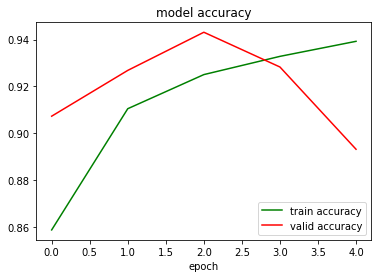

In [16]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

x_axis = np.arange(0,5) #number of epochs
plt.plot(x_axis, acc, color='green', label='train accuracy')

plt.plot(x_axis, val_acc, color='red', label='valid accuracy')

plt.title('model accuracy')
plt.legend()
plt.xlabel('epoch')
plt.show()

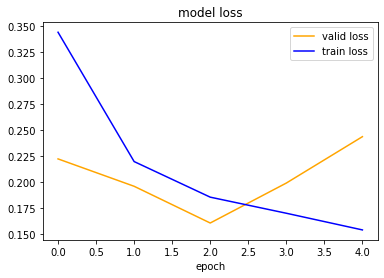

In [17]:
plt.plot(x_axis, val_loss, color='orange', label='valid loss')
plt.plot(x_axis, loss, color='blue', label='train loss')
plt.title('model loss')
plt.legend()
plt.xlabel('epoch')
plt.show()

In [ ]:
import cv2
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
def prediction(path_to_image):
  img = load_img(path_to_image,target_size=(IMAGE_SIZE, IMAGE_SIZE))
  plt.imshow(img)
  img_ = img_to_array(img)
  img_ = np.reshape(img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))
  pred = np.argmax(covid_detector(img_))
  return CLASSES[pred]



'Normal'

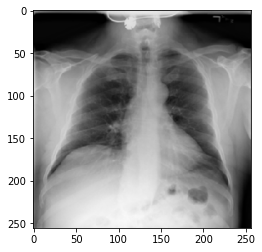

In [ ]:
path_to_image = '/content/COVID-19_Radiography_Dataset/Normal/Normal-10000.png'
prediction(path_to_image)

In [ ]:
covid_detector.save('/content/drive/MyDrive/Colab_models/covid19/covid_dectec.h5')